<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/video-rag-works/03_multi_modal_video_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multimodal RAG using Gemini-Pro Vision

In this notebook, we showcase a Multimodal RAG architecture designed for video processing. We utilize Gemini-Pro Vision MultiModal LLM class that employs Gemini embeddings to generate multimodal embeddings. Furthermore, we use [LanceDBVectorStore](https://docs.llamaindex.ai/en/latest/examples/vector_stores/LanceDBIndexDemo.html#) for efficient vector storage.



Steps:
1. Download video from https://www.pexels.com/, process and store it.

2. Build Multi-Modal index and vector store for both texts and images.

3. Retrieve relevant images and context, use both to augment the prompt.

4. Using Gemini-Pro Vision for reasoning the correlations between the input query and augmented data and generating final response.


**Reference**:

https://docs.llamaindex.ai/en/stable/examples/multi_modal/multi_modal_video_RAG/

https://medium.com/llamaindex-blog/multimodal-rag-for-advanced-video-processing-with-llamaindex-lancedb-33be4804822e

https://docs.llamaindex.ai/en/stable/examples/multi_modal/gemini/

https://medium.aiplanet.com/multimodal-rag-using-llamaindex-gemini-and-qdrant-f52c5b68b367

## Setup

In [ ]:
%pip install llama-index-multi-modal-llms-gemini

In [ ]:
%pip install llama-index-vector-stores-lancedb

In [ ]:
%pip install llama-index-embeddings-gemini

In [ ]:
%pip install llama-index-embeddings-clip

In [ ]:
%pip install llama_index ftfy regex tqdm
%pip install -U openai-whisper
%pip install git+https://github.com/openai/CLIP.git
%pip install torch torchvision
%pip install matplotlib scikit-image
%pip install lancedb
%pip install moviepy
%pip install pytube
%pip install pydub
%pip install SpeechRecognition
%pip install ffmpeg-python
%pip install soundfile

In [ ]:
!pip3 install pexelsPy

In [ ]:
from moviepy.editor import VideoFileClip
from pathlib import Path
import speech_recognition as sr
from pytube import YouTube
from pprint import pprint

In [ ]:
import os
from google.colab import userdata

GOOGLE_API_KEY = userdata.get("GOOGLE_API_KEY")  # add your GOOGLE API key here
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

## Video Downloading

In [ ]:
# video_url = "https://www.youtube.com/watch?v=d_qvLDhkg00"
output_video_path = "./video_data/"
output_folder = "./mixed_data/"
output_audio_path = "./mixed_data/output_audio.wav"

# filepath = output_video_path + "input_vid.mp4"
Path(output_folder).mkdir(parents=True, exist_ok=True)

In [ ]:
!rm -rf mixed_data/*
!rm -rf video_data/*
!rm -rf output_video_path

In [ ]:
import requests
import pexelsPy
import os

PEXELS_API = userdata.get("PIXEL_API_KEY")
api = pexelsPy.API(PEXELS_API)

pageNumbers = 1
resultsPage = 5

api.search_videos('conference videos', page=pageNumbers, results_per_page=resultsPage)
videos = api.get_videos()


for data in videos:
    url_video = 'https://www.pexels.com/video/' + str(data.id) + '/download'
    r = requests.get(url_video)
    with open(data.url.split('/')[-2]+'.mp4', 'wb') as outfile:
        outfile.write(r.content)

In [ ]:
!mkdir $output_video_path
!mv *.mp4 $output_video_path

In [ ]:
# base_path = "/content/sample_video/"
videos= os.listdir(output_video_path)
videos

['woman-using-digital-tablet-7534734.mp4',
 'happy-people-working-together-7534401.mp4',
 'a-group-of-business-people-working-in-unity-6774847.mp4',
 'a-woman-talking-in-a-business-conference-8717011.mp4',
 'man-writing-on-notebook-7534468.mp4']

## Video Preprocessing  Pipeline

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import os


def plot_images(image_paths):
    images_shown = 0
    plt.figure(figsize=(16, 9))
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path)

            plt.subplot(2, 3, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 7:
                break

In [ ]:
def video_metadata(title, views):
    metadata = {"Title": title, "Views": views}
    return metadata


def video_to_images(video_path, output_folder):
    """
    Convert a video to a sequence of images and save them to the output folder.

    Parameters:
    video_path (str): The path to the video file.
    output_folder (str): The path to the folder to save the images to.

    """
    clip = VideoFileClip(video_path)
    clip_resized = clip.resize(height=512)
    clip_resized.write_images_sequence(
        os.path.join(output_folder, "frame%04d.png"), fps=0.2
    )


def video_to_audio(video_path, output_audio_path):
    """
    Convert a video to audio and save it to the output path.

    Parameters:
    video_path (str): The path to the video file.
    output_audio_path (str): The path to save the audio to.

    """
    is_audio = False
    clip = VideoFileClip(video_path)
    audio = clip.audio
    if audio:
      audio.write_audiofile(output_audio_path)
      is_audio = True
    return is_audio


def audio_to_text(audio_path):
    """
    Convert audio to text using the SpeechRecognition library.

    Parameters:
    audio_path (str): The path to the audio file.

    Returns:
    test (str): The text recognized from the audio.

    """
    recognizer = sr.Recognizer()
    audio = sr.AudioFile(audio_path)

    with audio as source:
        # Record the audio data
        audio_data = recognizer.record(source)

        try:
            # Recognize the speech
            text = recognizer.recognize_whisper(audio_data)
        except sr.UnknownValueError:
            print("Speech recognition could not understand the audio.")
        except sr.RequestError as e:
            print(f"Could not request results from service; {e}")

    return text

In [ ]:
def video_preprocessing_pipeline(title, views, filepath):
  try:
      metadata_vid = video_metadata(title, views)
      video_to_images(filepath, output_folder)
      is_audio = video_to_audio(filepath, output_audio_path)
      text_data = None
      if is_audio:
        text_data = audio_to_text(output_audio_path)

      if text_data:
        with open(output_folder + "output_text.txt", "w") as file:
            file.write(text_data)
        print("Text data saved to file")
        file.close()
        os.remove(output_audio_path)
        print("Audio file removed")

  except Exception as e:
      raise e
  return metadata_vid

## Multi-modal indexing

In [ ]:
from llama_index.core import Settings
from llama_index.embeddings.gemini import GeminiEmbedding
from llama_index.llms.gemini import Gemini

# By default, LlamaIndex uses OpenAI LLM and embedding, so need to update the default embed_model and LLM
Settings.embed_model = GeminiEmbedding(
    model_name="models/embedding-001", api_key=GOOGLE_API_KEY
)
Settings.llm = Gemini(api_key=GOOGLE_API_KEY)

In [ ]:
from llama_index.core.indices import MultiModalVectorStoreIndex
from llama_index.core import SimpleDirectoryReader, StorageContext

from llama_index.core import SimpleDirectoryReader, StorageContext
from llama_index.vector_stores.lancedb import LanceDBVectorStore


from llama_index.core import SimpleDirectoryReader

text_store = LanceDBVectorStore(uri="lancedb", table_name="text_collection")
image_store = LanceDBVectorStore(uri="lancedb", table_name="image_collection")

storage_context = StorageContext.from_defaults(
    vector_store=text_store, image_store=image_store
)

def build_multimodal_index():
  # Create the MultiModal index
  documents = SimpleDirectoryReader(output_folder).load_data()

  index = MultiModalVectorStoreIndex.from_documents(
      documents,
      storage_context=storage_context,
  )
  return index

```log
[
  {"Happy People Working Together": 510},
  {"A Woman Talking in a Business Conference": 185},
  {"Man Writing on notebook": 123},
  {"Woman using Digital Tablet": 160},
  {"A Group Of Business People Working In Unity": 539}
]
```

In [ ]:
videos

['woman-using-digital-tablet-7534734.mp4',
 'happy-people-working-together-7534401.mp4',
 'a-group-of-business-people-working-in-unity-6774847.mp4',
 'a-woman-talking-in-a-business-conference-8717011.mp4',
 'man-writing-on-notebook-7534468.mp4']

In [ ]:
!rm -rf mixed_data/*

In [ ]:
title = "Woman using Digital Tablet"
views = 160
raw_videos = videos[0]
filepath = f"{output_video_path}/{raw_videos}"

metadata_vid = video_preprocessing_pipeline(title, views, filepath)
index = build_multimodal_index()

Moviepy - Writing frames ./mixed_data/frame%04d.png.


Moviepy - Done writing frames ./mixed_data/frame%04d.png.


In [ ]:
# Use index as retriever to fetch top k (5 in this example) results from the multimodal vector index
retriever_engine = index.as_retriever(
    similarity_top_k=5, image_similarity_top_k=5
)

## Prompt fine-tuning

In [ ]:
import json

metadata_str = json.dumps(metadata_vid)

qa_tmpl_str = (
    "Given the provided information, including relevant images and retrieved context from the video, \
 accurately and precisely answer the query without any additional prior knowledge.\n"
    "Please ensure honesty and responsibility, refraining from any racist or sexist remarks.\n"
    "---------------------\n"
    "Context: {context_str}\n"
    "Metadata for video: {metadata_str} \n"
    "---------------------\n"
    "Query: {query_str}\n"
    "Answer: "
)

In [ ]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode


# Retrieve most similar text/image embeddings baseed on user query from the DB
def retrieve(retriever_engine, query_str):
    retrieval_results = retriever_engine.retrieve(query_str)

    retrieved_image = []
    retrieved_text = []
    for res_node in retrieval_results:
        if isinstance(res_node.node, ImageNode):
            retrieved_image.append(res_node.node.metadata["file_path"])
        else:
            display_source_node(res_node, source_length=200)
            retrieved_text.append(res_node.text)

    return retrieved_image, retrieved_text

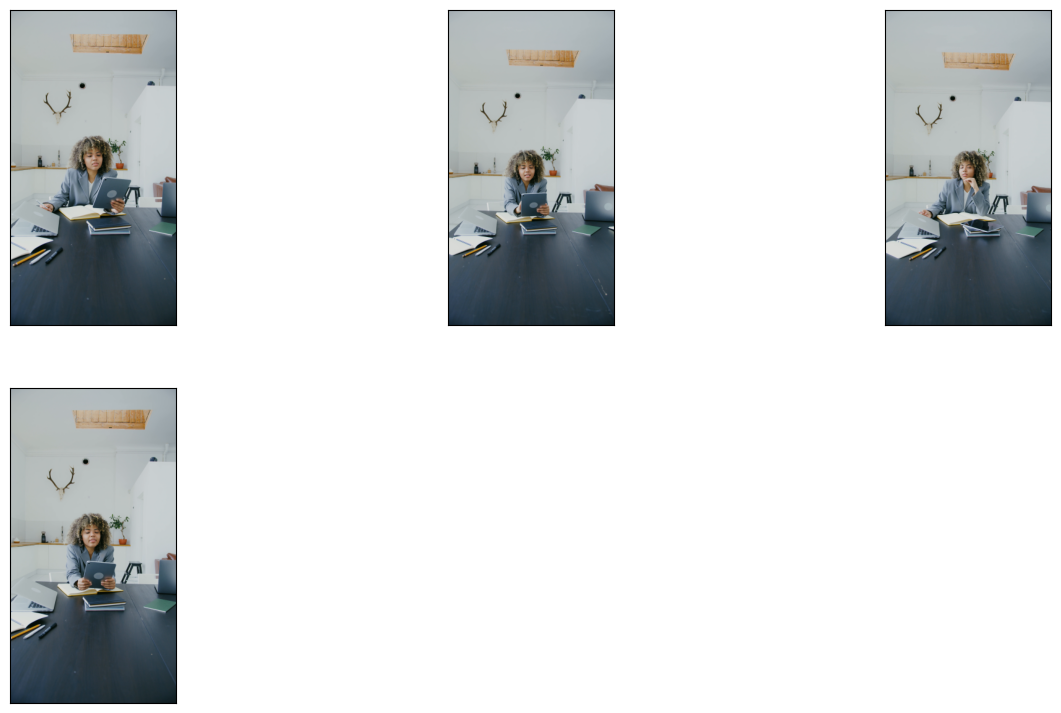

In [ ]:
# Add query now, fetch relevant details including images and augment the prompt template
query_str = "Using examples from video, explain all things covered in the video regarding the meeting"

img, txt = retrieve(retriever_engine=retriever_engine, query_str=query_str)
image_documents = SimpleDirectoryReader(
    input_dir=output_folder, input_files=img
).load_data()
context_str = "".join(txt)
plot_images(img)

## Response generation

In [ ]:
from llama_index.multi_modal_llms.gemini import GeminiMultiModal

gemini_pro = GeminiMultiModal(model_name="models/gemini-pro-vision")


response_1 = gemini_pro.complete(
    prompt=qa_tmpl_str.format(
        context_str=context_str, query_str=query_str, metadata_str=metadata_str
    ),
    image_documents=image_documents,
)

pprint(response_1.text)

(' The video shows a woman using a digital tablet while sitting at a table. '
 'She is wearing a suit and has curly hair. The table is made of wood and has '
 'a black finish. On the table are two laptops, a notebook, a pen, and a '
 'pencil. The woman is looking at the digital tablet and appears to be working '
 'on something.')


```log
(' The video shows a group of business people working in unity. They are '
 'discussing ideas, brainstorming, and working together to find solutions. '
 "They are also having fun and enjoying each other's company. The video is a "
 'positive example of how people can work together to achieve great things.')
 ```